#Ozan Ilhan, s3559513; Volodymyr Kalinin, s3648214

In [ ]:
# Install NLTK
!python -m pip install numpy nltk svgling

In [ ]:
# Download the Brown Corpus
import nltk
nltk.download('brown')

# Imports
from typing import List, Tuple

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


# Natural Language Processing Assignment 1: The Notebook

This is the notebook for the first hand-in assignment for Natural Language Processing. The notebook counts for 50% of the total assignment, which counts towards 15% of the final grade.

## Assignment 5 (20 points)

In the exercises you had the opportunity to practice with fitting $n$-gram language models on the Brown corpus. In this assignment you will fit an interpolated model and learn how to avoid zero counts by exploiting a heldout set.

In [ ]:
# Imports + code from exercises
from nltk.corpus import brown
import random
from nltk.lm import MLE, Laplace
from nltk.lm.api import LanguageModel
from nltk.lm.preprocessing import padded_everygram_pipeline

def split_data(data, train_ratio: float, heldout_ratio: float):
    random.Random(42).shuffle(data)
    train_cutoff = int(train_ratio*len(data))
    heldout_cutoff = int((train_ratio+heldout_ratio)*len(data))
    return {'train': data[:train_cutoff], 'heldout': data[train_cutoff:heldout_cutoff], 'test': data[heldout_cutoff:]}

# data: a list of (unpadded) sentences that are split into words
# n: the maximum order of n-grams to include
# model_type: parameter to support different types of language models
def fit_language_model(data: List[List[str]], n: int, model_type=MLE):
    train, vocab = padded_everygram_pipeline(n, data)
    model = model_type(n)
    model.fit(train, vocab)
    return model

def evaluate_language_model(model: LanguageModel, test_data: List[str], n: int):
    # Note that `padded_everygram_pipeline' adds n-1 SOS and EOS symbols
    # which trickles through in calculating perplexity.
    # For example, padding for n=3 will add the bigram for (<s>, <s>) which is NOT present in the model for n=2.
    gram_data, _ = padded_everygram_pipeline(n, test_data)
    test_grams = [x for t in gram_data for x in model.vocab.lookup(t) if len(x)==n]
    return model.perplexity(test_grams)

# Prepare data
non_fiction = brown.sents(categories=['editorial', 'government', 'learned', 'news', 'reviews'])
non_fiction = [s for s in non_fiction if len(s)>=3]

fiction = brown.sents(categories=['adventure', 'fiction', 'lore', 'mystery', 'romance', 'science_fiction'])
fiction = [s for s in fiction if len(s)>=3]

fiction_data = split_data(fiction, 0.9, 0.05)
non_fiction_data = split_data(non_fiction, 0.9, 0.05)

### Part 5.1: training a language model (10 points)

You may recall from the exercises that a simple smoothed language model doesn't perform so well on a test set, and generates strange examples. In this assignment you will investigate the use of an interpolated language model, combining it with parameters extracted from a heldout set.

Given are the following data: like in the exercises, we work with the Brown corpus and specifically the fiction and non-fiction texts of the corpus. Moreover, we will fix all data to contain all $n$-grams up to $n=3$.

As a first step, make sure you have fiction and non-fiction models available with Laplace smoothing (you may have fit these in the exercises already). Then, fit similar models but now use the `AbsoluteDiscountingInterpolated` model type, that implements absolute discounting. Calculate the perplexity to realize that once again there will be zero counts because the model is unsmoothed.

In [ ]:
# Part 5.1 SOLUTION:
from nltk.lm import AbsoluteDiscountingInterpolated

n = 3
fiction_laplace_model = fit_language_model(fiction_data['train'], n, Laplace)
non_fiction_laplace_model = fit_language_model(non_fiction_data['train'], n, Laplace)

fiction_discounting_model = fit_language_model(fiction_data['train'], n, AbsoluteDiscountingInterpolated)
non_fiction_discounting_model = fit_language_model(non_fiction_data['train'], n, AbsoluteDiscountingInterpolated)

fiction_laplace_perplexity = evaluate_language_model(fiction_laplace_model, fiction_data['test'], n)
non_fiction_laplace_perplexity = evaluate_language_model(non_fiction_laplace_model, non_fiction_data['test'], n)

fiction_discounting_perplexity = evaluate_language_model(fiction_discounting_model, fiction_data['test'], n)
non_fiction_discounting_perplexity = evaluate_language_model(non_fiction_discounting_model, non_fiction_data['test'], n)

print(f"The perplexity of the Laplace model on the fiction test data is: {fiction_laplace_perplexity}")
print(f"The perplexity of the Laplace model on the non-fiction test data is: {non_fiction_laplace_perplexity}")
print(f"The perplexity of the interpolated model on the fiction test data is: {fiction_discounting_perplexity}")
print(f"The perplexity of the interpolated model on the non-fiction test data is: {non_fiction_discounting_perplexity}")

The perplexity of the Laplace model on the fiction test data is: 8015.362978808722
The perplexity of the Laplace model on the non-fiction test data is: 13087.796641479064
The perplexity of the interpolated model on the fiction test data is: inf
The perplexity of the interpolated model on the non-fiction test data is: inf


### Part 5.2: avoiding zero counts (10 points)

One way of avoiding zero counts is to make sure that unseen words are mapped to a special token `<UNK>` (unknown). But how do we quantify the $n$-gram probability of unknown words? Well, we can use the held out set to estimate these counts. The implementation of language models in NLTK then allows us to simply *update* a language model with more data.

Hence, your assignment here is to implement the method `update_model` below. It takes three inputs: a language model, the heldout data, and the parameter `n` for the maximum $n$-grams to include. What the method should do:

 1. Use the language model's vocabulary to map unseen words of the heldout data to the `<UNK>` token,
 2. Generate the $n$-grams for the (tokenized) heldout data,
 3. Update the language model with these counts

After successful implementation of the method, use it to update the interpolated model and calculate its perplexity. How does it compare to the perplexity of the Laplace smoothed model?

*Hint: you may take inspiration from the method `evaluate_language_model` above.*

In [ ]:
# Part 5.2 SOLUTION:

def update_model(model: LanguageModel, heldout_data: List[List[str]], n: int):
    updated_heldout_data = []
    # go through the heldout data and map unseen words to <UNK>
    for sentence in heldout_data:
        for word in sentence:
            if word in model.vocab:
                updated_heldout_data.append(word)
            else:
                updated_heldout_data.append('<UNK>')
    heldout, _ = padded_everygram_pipeline(n, updated_heldout_data)

    # use the model.vocab since because we are mapping unseen words to the vocabulary of the model
    model.fit(heldout, model.vocab)

update_model(fiction_discounting_model, fiction_data['heldout'], n)
update_model(non_fiction_discounting_model, non_fiction_data['heldout'], n)

updated_fiction_discounting_perplexity = evaluate_language_model(fiction_discounting_model, fiction_data['test'], n)
updated_non_fiction_discounting_perplexity = evaluate_language_model(non_fiction_discounting_model, fiction_data['test'], n)

print(f"The perplexity of the updated interpolated model on the fiction test data is: {updated_fiction_discounting_perplexity}, the old perplexity was: {fiction_discounting_perplexity}.")
print(f"The perplexity of the updated interpolated model on the non-fiction test data is: {updated_non_fiction_discounting_perplexity}, the old perplexity was: {non_fiction_discounting_perplexity}.")

The perplexity of the updated interpolated model on the fiction test data is: 267.0908535777575, the old perplexity was: inf.
The perplexity of the updated interpolated model on the non-fiction test data is: 472.7387360379157, the old perplexity was: inf.


## Assignment 6: part-of-speech tagging (20 points)

This assignment consists of two parts in which you will consider parts-of-speech (POS) and POS tagging.

### Part 6.1: Ambiguity in open and closed class words (10 points)

In the lecture and in the exercises you saw that a small portion of words is ambiguous, but they nevertheless cover a large portion of text corpora. You also learnt about the distinction between open (i.e. dynamic words that may appear and disappear over time) and closed class words (i.e. pretty much fixed sets of words).

Below are two lists: one corresponds to closed class words, and another corresponds to open class words. We wish to inspect the ambiguity of words that are open class and words that are open class, and figure out whether words can belong to both!

Your task is as follows:
1. Determine the percentage of *unique* words that occur both as open class and as closed class words. I.e. out of all *unique* words, how many of them have been tagged at least once as open and and at least once as closed class?
2. For the *unique* words that only occur as either open class words or closed class words, calculate the percentage of *unique* words in each class that is may receive multiple POS tags (in their respective class). Do you find that open class words are more ambiguous, or less ambiguous then closed class words?

*Hint: If you run into any performance issues because of iterating over large lists, remember that you can convert a list into a set first and then membership lookup in Python becomes linear.*

In [ ]:
from nltk.corpus import treebank
nltk.download('treebank') # i had to add this because it was giving an error

all_word_tags = [word_tag for tagged_sentence in treebank.tagged_sents() for word_tag in tagged_sentence]
closed_class_tags = [',', '$', '.', 'CD', 'CC', 'RP', "''", '``', 'IN', 'TO',':', 'DT', 'WP', 'PRP',
                     'SYM', 'EX', 'PRP$', 'POS', 'MD']
open_class_tags = ['JJ', 'JJR', 'JJS', 'VBG', 'VBN', 'VB', 'NNP', 'VBD', 'NN', 'NNS',  'VBZ', 'VBP', 'NNPS']
other_tags = ['RBR', '-LRB-', 'PDT', 'WRB', 'WDT', 'RB', 'LS', 'WP$',  'UH',
              'FW', '-RRB-',  'RBS', '#', '-NONE-']

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


In [ ]:
# 6.1 SOLUTION:

# find which words belongs to the open class and closed class
all_word_tags = set(all_word_tags)
open_class_words = set()
closed_class_words = set()
for word, tag in all_word_tags:
    if tag in open_class_tags:
        open_class_words.add(word)
    if tag in closed_class_tags:
        closed_class_words.add(word)

# find the percentage of unique words that are both open class and closed class words
words_in_both_classes = open_class_words & closed_class_words
total_unique_words = len(open_class_words.union(closed_class_words))
both_classes_percentage = len(words_in_both_classes) / total_unique_words * 100
print(f"Percentage of unique words that are both open class and closed class words: {round(both_classes_percentage, 2)}%")

open_class_dict = dict()
closed_class_dict = dict()

# map each word to its tags in a dictionary for both open and closed class words
for word, tag in all_word_tags:
    if tag in open_class_tags:
        if word in open_class_dict:
            open_class_dict[word].add(tag)
        else:
            open_class_dict[word] = {tag} # a set is needed here to handle removing duplicate tags
    if tag in closed_class_tags:
        if word in closed_class_dict:
            closed_class_dict[word].add(tag)
        else:
            closed_class_dict[word] = {tag}

# find the percentage of ambiguous words in the open and closed class by looking at the dictionary for words with multiple tags
ambiguous_open_class_words = []
for word, tag in open_class_dict.items():
    if len(tag) > 1:
        ambiguous_open_class_words.append(word)

amibigious_closed_class_words = []
for word, tag in closed_class_dict.items():
    if len(tag) > 1:
        amibigious_closed_class_words.append(word)
open_class_percentage = len(ambiguous_open_class_words) / len(open_class_dict) * 100
closed_class_percentage = len(amibigious_closed_class_words) / len(closed_class_dict) * 100

print(f"Percentage of ambiguous open class words: {round(open_class_percentage, 1)}%")
print(f"Percentage of ambiguous closed class words: {round(closed_class_percentage, 1)}%")
print()
print("The open class words are more ambigious than the closed class words, since these words are more likely to have multiple tags.")

Percentage of unique words that are both open class and closed class words: 0.38%
Percentage of ambiguous open class words: 10.1%
Percentage of ambiguous closed class words: 2.1%

The open class words are more ambigious than the closed class words, since these words are more likely to have multiple tags.


### Part 6.2: Smoothing a tagger (10 points)

In the exercises you trained an HMM tagger that used `LidstoneProbDist` as an estimator for its probability distributions. This estimator generally applies some form of smoothing for its probability calculation. In general this would mean that the probability of a transition from one tag to the other is defined as:

$$ P_{\beta}(t_i | t_{i-1}) = \frac{C(t_{i-1} t_i) + \beta}{C(t_{i-1}) + \beta \cdot V} $$
        
where $V$ is the number of possible tags. A similar smoothing applies to the calculation of emission probabilities $P(w_i | t_i)$.

In the exercises the smoothing parameter was set as $\beta=0.1$.

In this assignment, you will try to find a better parameter on a given dataset. The code below loads in a portion of the Penn Treebank and has code for training and testing a Hidden Markov Model tagger.

Your task is the following:

1. Train a tagger with smoothing parameter $0.1$ and verify that its accuracy is $0.917$,
2. Train an unsmoothed tagger, i.e. the smoothing parameter should be set to $0$, and report its accuracy,
3. Now find a smoothing value for which the corresponding model reaches an accuracy greater than $0.917$. Is it higher or lower than $0.1$?

In [ ]:
from nltk import LidstoneProbDist
from nltk.tag.hmm import load_pos, HiddenMarkovModelTrainer, HiddenMarkovModelTagger
from nltk.lm import MLE, Laplace

from tqdm import tqdm

def train_hmm_tagger(train_data: List[List[Tuple[str, str]]],
                     estimator=lambda fd, bins: LidstoneProbDist(fd, 0.1, bins)) -> HiddenMarkovModelTagger:
    tags = list(set([t for s in train_data for w,t in s]))
    words = list(set([w for s in train_data for w,t in s]))
    trainer = HiddenMarkovModelTrainer(tags, words)
    hmm = trainer.train_supervised(train_data, estimator=estimator)
    return hmm

def test_hmm_tagger(tagger: HiddenMarkovModelTagger, test_data: List[List[Tuple[str, str]]]) -> List[List[Tuple[str, str]]]:
    # we put disable=True to avoid the progress bar in the output
    return [tagger.tag([w for w,t in s]) for s in tqdm(test, position=0, disable=True)]

def accuracy(trues: List[str], predictions: List[str]):
    return sum([t == p for t, p in zip(trues, predictions)])/len(trues)

In [ ]:
from nltk.corpus import treebank

import random

def split_data(data, cutoff=0.98):
    random.Random(42).shuffle(data)
    return data[:int(cutoff*len(data))], data[int(cutoff*len(data)):]

train, test = split_data(list(treebank.tagged_sents()), cutoff=0.9)
display(len(train), len(test))

3522

392

In [ ]:
# 6.2 SOLUTION:
hmm_tagger_0_1 = train_hmm_tagger(train)
predictions_0_1 = test_hmm_tagger(hmm_tagger_0_1, test)
test_tags = [tag for sentence in test for (word, tag) in sentence]
predicted_tags_0_1 = [tag for sentence in predictions_0_1 for (word, tag) in sentence]
accuracy_0_1 = accuracy(test_tags, predicted_tags_0_1)
print(f"Accuracy with beta = 0.1: {round(accuracy_0_1, 3)}")

hmm_tagger_0 = train_hmm_tagger(train, estimator=lambda fd, bins: LidstoneProbDist(fd, 0, bins))
predictions_0 = test_hmm_tagger(hmm_tagger_0, test)
predicted_tags_0 = [tag for sentence in predictions_0 for (word, tag) in sentence]
accuracy_0 = accuracy(test_tags, predicted_tags_0)
print(f"Accuracy with beta = 0: {round(accuracy_0, 4)}")

beta_values  = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.5, 1]
accuracies = []
for beta in beta_values:
    hmm_tagger = train_hmm_tagger(train, estimator=lambda fd, bins: LidstoneProbDist(fd, beta, bins))
    predictions = test_hmm_tagger(hmm_tagger, test)
    predicted_tags = [tag for sentence in predictions for (word, tag) in sentence]
    accuracy_tagger = accuracy(test_tags, predicted_tags)
    print(f"Accuracy with beta = {beta}: {round(accuracy_tagger, 4)}")
    accuracies.append((beta, accuracy_tagger))

best_beta, best_accuracy = max(accuracies, key=lambda x: x[1]) # find the beta value with the highest accuracy

print(f"The best smoothing value is: {best_beta}, which gives an accuracy of: {round(best_accuracy, 4)}. This is higher than 0.917.")

Accuracy with beta = 0.1: 0.917


/usr/local/lib/python3.10/dist-packages/nltk/tag/hmm.py:334: RuntimeWarning: overflow encountered in cast
  X[i, j] = self._transitions[si].logprob(self._states[j])
/usr/local/lib/python3.10/dist-packages/nltk/tag/hmm.py:336: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
/usr/local/lib/python3.10/dist-packages/nltk/tag/hmm.py:332: RuntimeWarning: overflow encountered in cast
  P[i] = self._priors.logprob(si)
/usr/local/lib/python3.10/dist-packages/nltk/tag/hmm.py:364: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])


Accuracy with beta = 0: 0.4079
Accuracy with beta = 0.001: 0.9192
Accuracy with beta = 0.005: 0.9213
Accuracy with beta = 0.01: 0.9221
Accuracy with beta = 0.05: 0.9213
Accuracy with beta = 0.1: 0.917
Accuracy with beta = 0.15: 0.9137
Accuracy with beta = 0.2: 0.912
Accuracy with beta = 0.5: 0.8878
Accuracy with beta = 1: 0.8597
The best smoothing value is: 0.01, which gives an accuracy of: 0.9221. This is higher than 0.917.


## Assignment 7: parsing (20 points)

In this assignment, you will perform evaluation over a constituency parser. The first bit of code is taken from the exercises and sets up a probabilistic context-free grammar and a Viterbi parser for it, over a sample from the Penn Treebank.

In [ ]:
from nltk.tree.tree import Tree
from nltk.corpus import treebank
from nltk.grammar import Nonterminal, induce_pcfg
from nltk.parse.viterbi import ViterbiParser

parsed_sents = treebank.parsed_sents()
grammar = induce_pcfg(Nonterminal("S"), [p for s in parsed_sents for p in s.productions()])
viterbi_parser = ViterbiParser(grammar)

The code below loads and displays two example test trees (for the sentences `They will join the board .` and `The student will do the work on Monday .`) containing a few parsing errors.

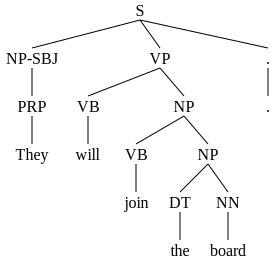

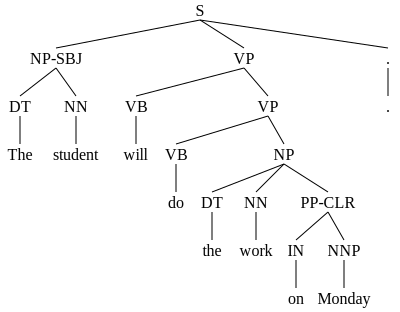

In [ ]:
with open('example_trees.txt', 'r') as in_file:
    example_trees = [Tree.fromstring(s.strip()) for s in in_file.readlines()]

display(example_trees[0])
display(example_trees[1])

The code below will compute the span representation for a given tree, as a first step in calculating parser evaluation metrics (precision, recall, F1).



In [ ]:
from typing import Tuple, List

def get_leaf_position_for_idx(tree, idx):
    return [i for i in range(len(tree.leaves())) if tree.leaf_treeposition(i) == idx][0]

def get_span_for_index(tree: Tree, idx: Tuple[int,...]):
    return [get_leaf_position_for_idx(tree, p) for p in tree.treepositions()
            if p[:len(idx)] == idx and isinstance(tree[p], str)]

def get_internal_node_idxs(tree: Tree) -> List[Tuple[int,...]]:
    return [i for i in tree.treepositions() if isinstance(tree[i], Tree) and tree[i].height() > 1]

def compute_labeled_span_for_node(tree: Tree, idx: Tuple[int,...]) -> Tuple[str, int, int]:
    label = tree[idx].label()
    span = get_span_for_index(tree, idx)
    return label, span[0], span[-1]

def string_for_lspan(label: str, left: int, right: int):
    return f"{label}({left},{right})"

def get_labelled_spans_for_tree(tree: Tree) -> List[Tuple[str, int, int]]:
    # First grab the tree indices for internal nodes
    internal_node_indices = get_internal_node_idxs(tree)
    # Compute the labelled spans for all internal nodes
    labelled_spans = [compute_labeled_span_for_node(tree, idx) for idx in internal_node_indices]
    return [string_for_lspan(label, left, right) for label, left, right in labelled_spans]

In [ ]:
example_spans1 = get_labelled_spans_for_tree(example_trees[0])
example_spans2 = get_labelled_spans_for_tree(example_trees[1])

display(example_spans1)
display(example_spans2)

['S(0,5)',
 'NP-SBJ(0,0)',
 'PRP(0,0)',
 'VP(1,4)',
 'VB(1,1)',
 'NP(2,4)',
 'VB(2,2)',
 'NP(3,4)',
 'DT(3,3)',
 'NN(4,4)',
 '.(5,5)']

['S(0,8)',
 'NP-SBJ(0,1)',
 'DT(0,0)',
 'NN(1,1)',
 'VP(2,7)',
 'VB(2,2)',
 'VP(3,7)',
 'VB(3,3)',
 'NP(4,7)',
 'DT(4,4)',
 'NN(5,5)',
 'PP-CLR(6,7)',
 'IN(6,6)',
 'NNP(7,7)',
 '.(8,8)']

### Part 7.1: Parser evaluation (10 points)

Do the following:
- Use the Viterbi parser from the previous exercise to extract the parses for these sentences.
- Finish the implementation for precision, recall and F1 score and calculate these metrics for the parser output against the two test sentences. Verify that you get the following scores:

| Sentence        | Precision   | Recall | F1 |
|:------------- |:-------------:|:------:|:--:|
| `They will join the board .`      | 0.82 | 0.82 | 0.82 |
| `The student will do the work on Monday .`    | 0.87  | 0.81 | 0.84 |

In [ ]:
# 7.1 SOLUTION:
parsed_sentence1 = list(viterbi_parser.parse(example_trees[0].leaves()))[0]
parsed_sentence2 = list(viterbi_parser.parse(example_trees[1].leaves()))[0]

parsed_viterbi1 = get_labelled_spans_for_tree(parsed_sentence1)
parsed_viterbi2 = get_labelled_spans_for_tree(parsed_sentence2)

def calculate_metrics(example_spans, parsed_viterbi):
    example_spans = set(example_spans)
    parsed_viterbi = set(parsed_viterbi)
    correct_spans = example_spans & parsed_viterbi
    n_correct = len(correct_spans)
    n_example_spans = len(example_spans)
    n_viterbi = len(parsed_viterbi)

    if n_example_spans > 0:
        precision = n_correct / n_example_spans
    else:
        precision = 0

    if n_viterbi > 0:
        recall = n_correct / n_viterbi
    else:
        recall = 0

    if (precision + recall) > 0:
        f1 = (2 * precision * recall / (precision + recall))
    else:
        f1 = 0
    return precision, recall, f1

precision1, recall1, f1_1 = calculate_metrics(example_spans1, parsed_viterbi1)
precision2, recall2, f1_2 = calculate_metrics(example_spans2, parsed_viterbi2)

print(f"Sentence 1, Precision: {round(precision1, 2)}, Recall: {round(recall1, 2)}, F1: {round(f1_1, 2)}")
print(f"Sentence 2, Precision: {round(precision2, 2)}, Recall: {round(recall2, 2)}, F1: {round(f1_2, 2)}")
print("These scores are the same scores that were given.")

Sentence 1, Precision: 0.82, Recall: 0.82, F1: 0.82
Sentence 2, Precision: 0.87, Recall: 0.81, F1: 0.84
These scores are the same scores that were given.


### Part 7.1b (BONUS, 5 points):

This question can lead to bonus points, which may compensate any error you made elsewhere.

- What happens to the evaluation metrics if you switch the test tree and the parse tree around?
- What happens if you compare the first test tree against the second parsed sentence and vice versa?

In [ ]:
# 7.1b SOLUTION:
precision_switched1, recall_switched1, f1_switched1 = calculate_metrics(parsed_viterbi1, example_spans1)
precision_switched2, recall_switched2, f1_switched2 = calculate_metrics(parsed_viterbi2, example_spans2)

print("After switching the test tree and the parse tree around:")
print(f"Sentence 1, Precision: {round(precision_switched1, 2)}, Recall: {round(recall_switched1, 2)}, F1: {round(f1_switched1, 2)}")
print(f"Sentence 2, Precision: {round(precision_switched2, 2)}, Recall: {round(recall_switched2, 2)}, F1: {round(f1_switched2, 2)}")
print()
print("""The precision and recall are switched with each other when you do this,
because the predicted and actual spans are switched with each other and therefore also the precision and recall.
The F1 score remains the same.""")
print()

precision_compare1, recall_compare1, f1_compare1 = calculate_metrics(example_spans1, parsed_viterbi2)
precision_compare2, recall_compare2, f1_compare2 = calculate_metrics(example_spans2, parsed_viterbi1)
print("Comparing the first test tree against the second parsed sentence and vice versa:")
print(f"Sentence 1 and parsed sentence 2, Precision: {round(precision_compare1, 2)}, Recall: {round(recall_compare1, 2)}, F1: {round(f1_compare1, 2)}")
print(f"Sentence 2 and parsed sentence 1, Precision: {round(precision_compare2, 2)}, Recall: {round(recall_compare2, 2)}, F1: {round(f1_compare2, 2)}")
print()
print("""All scores get changed to very low values when you do this,
because the predicted spans are nothing like the actual span values anymore.
This leads to a lot of mismatches and thus low scores.""")

After switching the test tree and the parse tree around:
Sentence 1, Precision: 0.82, Recall: 0.82, F1: 0.82
Sentence 2, Precision: 0.81, Recall: 0.87, F1: 0.84

The precision and recall are switched with each other when you do this,
because the predicted and actual spans are switched with each other and therefore also the precision and recall.
The F1 score remains the same.

Comparing the first test tree against the second parsed sentence and vice versa:
Sentence 1 and parsed sentence 2, Precision: 0.0, Recall: 0.0, F1: 0
Sentence 2 and parsed sentence 1, Precision: 0.07, Recall: 0.09, F1: 0.08

All scores get changed to very low values when you do this,
because the predicted spans are nothing like the actual span values anymore.
This leads to a lot of mismatches and thus low scores.


### Part 7.2: Large-Scale evaluation (10 points)

Now we must find out a way to evaluate on a larger test set of sentences. This set is given in the file `test_trees.txt`, which is already loaded by the code below. Do the following:

1. Parse each of the sentences.
2. Calculate the micro-averaged precision, recall and F1 scores. That is, you must first aggregate all predictions and then calculate the overall metrics! This time, the trees in the test set correspond to the *correct parses*.

*Note: running over all the test trees may take a while. Although it shouldn't take more than a few minutes at most, it is recommended to use `tqdm` when iterating over the test trees to keep track of the progress, as indicated in the code below.*

In [ ]:
# 7.2 SOLUTION:
from tqdm import tqdm

with open('test_trees.txt', 'r') as in_file:
    test_trees = [Tree.fromstring(s.strip()) for s in in_file.readlines()]

all_parsed_spans = []
all_tree_spans = []
for tree in tqdm(test_trees, position=0):
    sentence = tree.leaves()
    parsed_sentence = list(viterbi_parser.parse(sentence))[0]
    parsed_spans = get_labelled_spans_for_tree(parsed_sentence)
    tree_spans = get_labelled_spans_for_tree(tree)
    all_parsed_spans.extend(parsed_spans)
    all_tree_spans.extend(tree_spans)

precision_micro, recall_micro, f1_micro = calculate_metrics(all_tree_spans, all_parsed_spans)

print(f"""Micro-averaged Precision: {round(precision_micro, 2)},
Micro-average Recall: {round(recall_micro, 2)},
Micro-averaged F1: {round(f1_micro, 2)}""")

100%|██████████| 50/50 [04:15<00:00,  5.11s/it]

Micro-averaged Precision: 0.78,
Micro-average Recall: 0.81,
Micro-averaged F1: 0.79
